In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tsai.all import *
from joblib import Parallel, delayed
from openavalancheproject.tsai_utilities import *
import numpy as np
import xarray as xr
from joblib import Parallel, delayed
import itertools, functools

In [3]:
season = '20-21'
state = 'Colorado'
region = 'Grand Mesa Zone'
data_root = '/media/scottcha/Data2/OAPMLData/'
interpolation = 1
processed_path = data_root + '/4.GFSFiltered'+ str(interpolation) + 'xInterpolationZarr/'

In [38]:
nc_ds = xr.open_dataset('/media/scottcha/Data2/OAPMLData/3.GFSFiltered1xInterpolation/20-21/Region_Grand Mesa Zone_20201101.nc')
nc_ds2 = xr.open_dataset('/media/scottcha/Data2/OAPMLData/3.GFSFiltered1xInterpolation/20-21/Region_Grand Mesa Zone_20210423.nc')

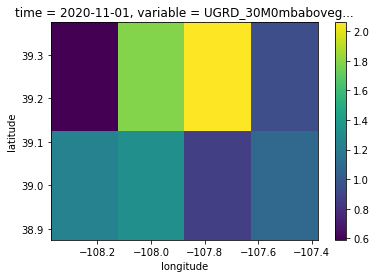

In [39]:
nc_ds.to_array().sel(variable='UGRD_30M0mbaboveground_max').plot()

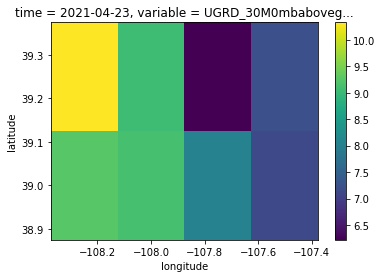

In [40]:
nc_ds2.to_array().sel(variable='UGRD_30M0mbaboveground_max').plot()

In [18]:
nc_ds_converted = nc_ds.to_array(name='vars').chunk({'time':1, 'latitude':1, 'longitude':1, 'variable':-1}).to_dataset()

In [19]:
nc_ds2_converted = nc_ds2.to_array(name='vars').chunk({'time':1, 'latitude':1, 'longitude':1, 'variable':-1}).to_dataset()

In [20]:
last_vars = list(nc_ds2_converted.variable.values)

In [76]:
nc_ds_converted.sortby('variable')

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 2, longitude: 4, variable: 1578)
Coordinates:
  * time       (time) datetime64[ns] 2020-11-01
  * latitude   (latitude) float64 39.0 39.25
  * longitude  (longitude) float64 -108.2 -108.0 -107.8 -107.5
  * variable   (variable) <U47 'ABSV_0D4mb_avg' ... 'var2_3_203_surface_min'
Data variables:
    vars       (variable, time, latitude, longitude) float64 dask.array<chunksize=(1578, 1, 1, 1), meta=np.ndarray>

In [21]:
final_vars = [v for v in list(nc_ds_converted.variable.values) if v in last_vars]

In [22]:
len(final_vars)

1578

In [23]:
nc_ds2_converted = nc_ds2_converted.sel(variable=nc_ds2_converted.variable.isin(final_vars))

In [74]:
nc_ds2_converted.sortby('variable')

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 2, longitude: 4, variable: 1578)
Coordinates:
  * time       (time) datetime64[ns] 2021-04-23
  * latitude   (latitude) float64 39.0 39.25
  * longitude  (longitude) float64 -108.2 -108.0 -107.8 -107.5
  * variable   (variable) <U47 'ABSV_0D4mb_avg' ... 'var2_3_203_surface_min'
Data variables:
    vars       (variable, time, latitude, longitude) float64 dask.array<chunksize=(1578, 1, 1, 1), meta=np.ndarray>

In [31]:
nc_ds_converted = nc_ds_converted.sel(variable=nc_ds_converted.variable.isin(final_vars))

In [33]:
nc_ds_converted.to_zarr('/media/scottcha/Data2/Temp/testzarr/', consolidated=True)

In [34]:
nc_ds2_converted.to_zarr('/media/scottcha/Data2/Temp/testzarr/', consolidated=True, append_dim='time')

In [35]:
new_ds = xr.open_zarr('/media/scottcha/Data2/Temp/testzarr/', consolidated=True)

In [36]:
new_ds = new_ds.sortby('variable').stack(lat_lon = ('latitude', 'longitude'))
new_ds = new_ds.vars.transpose('lat_lon', 'time', 'variable')

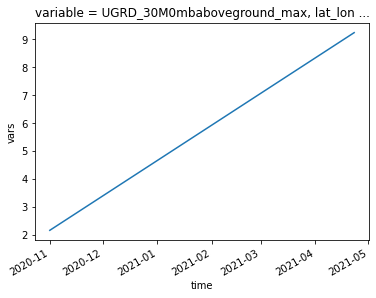

In [37]:
new_ds.isel(lat_lon=0).sel(variable='UGRD_30M0mbaboveground_max').plot()

In [10]:
seasons = ['15-16', '16-17', '17-18', '18-19', '19-20']# '20-21']
regions = ['Grand Mesa Zone', 'Sangre de Cristo Range', 'Steamboat Zone', 'Front Range Zone',
            'Vail Summit Zone', 'Sawatch Zone', 'Aspen Zone', 
            'North San Juan Mountains', 'South San Juan Mountains', 'Gunnison Zone']

In [126]:
#try and learn next day snowdepth
#state = self.get_state_for_region(region)
#earliest_data, season = PrepML.date_to_season(date)

path = processed_path + '/' + season + '/' + state + '/Region_' + region + '.zarr'


test_ds = xr.open_zarr(path, consolidated=True)

In [127]:
test_ds = test_ds.sortby('variable').stack(lat_lon = ('latitude', 'longitude'))
test_ds = test_ds.vars.transpose('lat_lon', 'time', 'variable')

In [4]:
window_length=180
stride = 1


In [129]:
test_ds.values.shape

(8, 181, 1578)

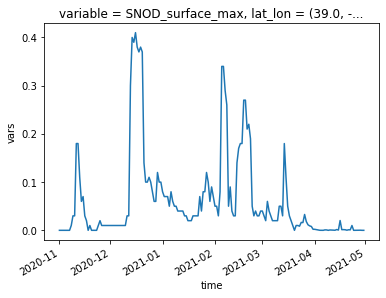

In [132]:
test_ds.isel(lat_lon=0).sel(variable='SNOD_surface_max').plot()

In [5]:
def process_file(tmp_ds, variables = None):
    tmp_ds = tmp_ds.sel(variable = tmp_ds['variable'].isin(variables))
    var_names = list(tmp_ds['variable'].values)
    snowdepth_index = var_names.index('SNOD_surface_max')
    X_indexes = list(range(0,len(var_names)))
    X_indexes.remove(snowdepth_index)
    X = None
    y = None
    for i in range(0,tmp_ds.shape[0]):
        tmp_X, tmp_y = SlidingWindow(window_length, stride=stride, pad_remainder=True, check_leakage=True, get_x=X_indexes, get_y=snowdepth_index)(tmp_ds[i])
        if i == 0:
            X = tmp_X
            y = tmp_y
        else:
            X = np.concatenate([X, tmp_X])
            y = np.concatenate([y, tmp_y])
    return X, y

In [6]:
var_small = ['WEASD_surface_max', 'SNOD_surface_max', 'UGRD_30M0mbaboveground_max', 'VGRD_30M0mbaboveground_max', 'TMP_surface_min', 'HGT_surface_min', 'VVEL_150mb_avg', 'APCP_surface_sum', 'ACPCP_surface_sum', 'WATR_surface_sum']

In [7]:
def process(t):    
    season = t[0]
    region = t[1]
    print(season + ' ' + region )
    path = processed_path + '/' + season + '/' + state + '/Region_' + region + '.zarr'
    tmp_ds = xr.open_zarr(path, consolidated=True)
    tmp_ds = tmp_ds.sortby('variable').stack(lat_lon = ('latitude', 'longitude'))
    tmp_ds = tmp_ds.vars.transpose('lat_lon', 'time', 'variable')
        
    X, y = process_file(tmp_ds, variables=var_small)
    return X, y

In [8]:
func = partial(process)

In [11]:
X_final = None
y_final = None
data = Parallel(n_jobs=20)(map(delayed(func), itertools.product(seasons, regions)))

In [12]:
X_final = data[0][0]
y_final = data[0][1]
for i in range(1, len(data)):
    X_final = np.concatenate([X_final, data[i][0]])
    y_final = np.concatenate([y_final, data[i][1]])                          

<AxesSubplot:>

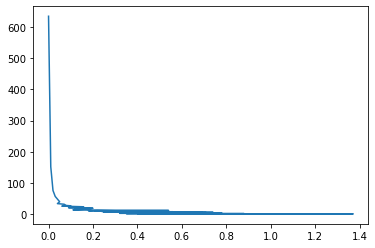

In [13]:
pd.Series(y_final).value_counts().plot()

In [14]:
print(X_final.shape)
print(y_final.shape)
    

(1659, 10, 180)
(1659,)


In [15]:
del data

In [16]:
X_test_final = None
y_test_final = None
data = Parallel(n_jobs=20)(map(delayed(func), itertools.product(['20-21'], regions)))

In [17]:
X_test_final = data[0][0]
y_test_final = data[0][1]
for i in range(1, len(data)):
    X_test_final = np.concatenate([X_test_final, data[i][0]])
    y_test_final = np.concatenate([y_test_final, data[i][1]])    

In [18]:
print(X_test_final.shape)
print(y_test_final.shape)

(237, 10, 180)
(237,)


In [29]:
y_test_final = np.round(y_test_final, 2)

In [32]:
pd.Series(y_test_final).value_counts()

0.00    157
0.01     38
0.02     30
0.03      4
0.04      2
0.05      2
0.10      2
0.09      1
0.06      1
dtype: int64

In [33]:
pd.Series(y_final).value_counts()

0.00    634
0.01    152
0.02     76
0.03     57
0.05     40
       ... 
0.98      1
0.93      1
1.02      1
0.90      1
0.79      1
Length: 85, dtype: int64

16-17 Aspen Zone
17-18 North San Juan Mountains
20-21 South San Juan Mountains
16-17 Gunnison Zone
18-19 Grand Mesa Zone
18-19 Vail Summit Zone
18-19 Aspen Zone
19-20 Grand Mesa Zone
19-20 Vail Summit Zone
20-21 Front Range Zone
16-17 Sawatch Zone
17-18 Grand Mesa Zone
17-18 South San Juan Mountains
20-21 North San Juan Mountains
16-17 Steamboat Zone
20-21 Steamboat Zone


In [28]:
y_test_final.shape

(237,)

16-17 Vail Summit Zone
17-18 Vail Summit Zone
18-19 Sangre de Cristo Range
19-20 North San Juan Mountains
15-16 Aspen Zone
17-18 Front Range Zone
20-21 Sawatch Zone
16-17 Front Range Zone
19-20 Sawatch Zone
20-21 Vail Summit Zone
15-16 Front Range Zone
19-20 Aspen Zone
20-21 Aspen Zone
15-16 Vail Summit Zone
17-18 Sawatch Zone
17-18 Gunnison Zone
18-19 Sawatch Zone
18-19 Gunnison Zone
20-21 Grand Mesa Zone
16-17 Grand Mesa Zone
17-18 Steamboat Zone
20-21 Gunnison Zone


In [27]:
np.round(y_test_final, 2).shape

(237,)

16-17 North San Juan Mountains
19-20 South San Juan Mountains
15-16 South San Juan Mountains
19-20 Steamboat Zone


In [30]:
np.save( data_root + '/transfer_X_final_small.npy', X_final)

In [31]:
np.save( data_root + '/transfer_X_test_final_small.npy', X_test_final)
np.save( data_root + '/transfer_y_final_small.npy', y_final)
np.save( data_root + '/transfer_y_test_final_small.npy', y_test_final)

15-16 Steamboat Zone
20-21 Sangre de Cristo Range


In [246]:
X_final = np.load( data_root + '/transfer_X_final_small.npy', mmap_mode='r+')
X_test_final = np.load(data_root + '/transfer_X_test_final_small.npy', mmap_mode='r+')
y_final = np.load(data_root + '/transfer_y_final_small.npy', mmap_mode='r+')
y_test_final = np.load(data_root + '/transfer_y_test_final_small.npy', mmap_mode='r+')

In [247]:
??get_ts_features

In [ ]:
ts_features_df = get_ts_features(np.nan_to_num(np.concatenate([X_final, X_test_final])), np.concatenate([y_final, y_test_final]), features='efficient', n_jobs=12)

Feature Extraction:   0%|                                                                        | 0/60 [00:00<?, ?it/s]

16-17 Grand Mesa Zone
17-18 Aspen Zone
18-19 Sangre de Cristo Range
19-20 North San Juan Mountains
15-16 Gunnison Zone
18-19 Front Range Zone
15-16 Sawatch Zone
17-18 Sangre de Cristo Range
19-20 Sangre de Cristo Range
15-16 Front Range Zone
19-20 Sawatch Zone
19-20 Gunnison Zone
16-17 Steamboat Zone
20-21 Steamboat Zone
16-17 Gunnison Zone
18-19 Steamboat Zone
15-16 Grand Mesa Zone
17-18 Sawatch Zone
17-18 Gunnison Zone
18-19 Sawatch Zone
18-19 North San Juan Mountains
15-16 Sawatch Zone
17-18 Sangre de Cristo Range
19-20 Sangre de Cristo Range
15-16 Front Range Zone
19-20 Sawatch Zone
19-20 Gunnison Zone
15-16 Sangre de Cristo Range
18-19 South San Juan Mountains
16-17 Vail Summit Zone
17-18 Steamboat Zone
20-21 South San Juan Mountains
16-17 Aspen Zone
17-18 Vail Summit Zone
18-19 Grand Mesa Zone
18-19 Vail Summit Zone
18-19 Sawatch Zone
18-19 North San Juan Mountains
16-17 Front Range Zone
19-20 Front Range Zone
15-16 Aspen Zone
17-18 Aspen Zone
18-19 Sangre de Cristo Range
19-20 F

Feature Extraction:   3%|██                                                           | 2/60 [18:29<7:26:57, 462.38s/it]

In [183]:
ts_features_df.head()

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__maximum,0__minimum,1__sum_values,1__median,...,8__minimum,9__sum_values,9__median,9__mean,9__length,9__standard_deviation,9__variance,9__maximum,9__minimum,target
0,13.66,0.0,0.455333,30.0,1.563009,2.442998,8.28,0.0,74.049999,0.03,...,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.16
1,13.66,0.0,0.455333,30.0,1.563009,2.442998,8.28,0.0,74.069999,0.04,...,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.15
2,13.66,0.0,0.455333,30.0,1.563009,2.442998,8.28,0.0,74.069999,0.04,...,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.15
3,13.66,0.0,0.455333,30.0,1.563009,2.442998,8.28,0.0,74.069999,0.04,...,1.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.15
4,5.38,0.0,0.179333,30.0,0.576963,0.332886,2.79,0.0,60.810000,0.01,...,1.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.09


In [184]:
ts_features_df = ts_features_df.fillna(value=0)

In [185]:
ts_features_df.shape

(215196, 81)

In [189]:
cont_names = ts_features_df.columns[:-1]
y_names = 'target'
dls_tab = get_tabular_dls(ts_features_df, splits=splits_2, cont_names=cont_names, y_names=y_names)
dls_tab.show_batch()

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__maximum,0__minimum,1__sum_values,1__median,1__mean,1__length,1__standard_deviation,1__variance,1__maximum,1__minimum,2__sum_values,2__median,2__mean,2__length,2__standard_deviation,2__variance,2__maximum,2__minimum,3__sum_values,3__median,3__mean,3__length,3__standard_deviation,3__variance,3__maximum,3__minimum,4__sum_values,4__median,4__mean,4__length,4__standard_deviation,4__variance,4__maximum,4__minimum,5__sum_values,5__median,5__mean,5__length,5__standard_deviation,5__variance,5__maximum,5__minimum,6__sum_values,6__median,6__mean,6__length,6__standard_deviation,6__variance,6__maximum,6__minimum,7__sum_values,7__median,7__mean,7__length,7__standard_deviation,7__variance,7__maximum,7__minimum,8__sum_values,8__median,8__mean,8__length,8__standard_deviation,8__variance,8__maximum,8__minimum,9__sum_values,9__median,9__mean,9__length,9__standard_deviation,9__variance,9__maximum,9__minimum,target
0,27.0,1.0,0.900000,30.0,0.943398,0.890000,4.0,0.0,135.000000,2.5,4.500000,30.0,6.206180,38.516666,29.0,0.0,101502.593750,3383.419922,3383.419922,30.0,0.0,0.0,3383.419922,3383.419922,7814.299805,260.450012,260.476654,30.0,3.684352,13.574451,267.299988,251.699997,114.110001,3.345000,3.803667,30.0,2.485792,6.179163,10.990000,0.130000,163.759995,5.445000,5.458667,30.0,2.710626,7.347491,11.870000,-1.050000,0.056343,-1.764286e-02,0.001878,30.0,0.124543,0.015511,0.302000,-0.286486,51.836395,1.7084,1.727880,30.0,0.823780,6.786136e-01,3.1412,0.3148,648.000000,22.000000,21.600000,30.0,8.333067,69.440002,33.0,5.000000e+00,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.05
1,0.0,0.0,0.000000,30.0,0.000000,0.000000,0.0,0.0,22.000000,0.0,0.733333,30.0,1.787612,3.195556,8.0,0.0,80960.890625,2698.696289,2698.696289,30.0,0.0,0.0,2698.696289,2698.696289,7919.725098,264.754822,263.990845,30.0,4.600526,21.164845,269.744080,252.316071,221.946060,5.898187,7.398202,30.0,6.404587,41.018730,26.746552,-1.334041,32.393063,0.929342,1.079769,30.0,1.163821,1.354478,5.038541,-0.313678,0.816080,1.660300e-02,0.027203,30.0,0.083161,0.006916,0.226775,-0.187752,0.727600,0.0224,0.024253,30.0,0.007217,5.207956e-05,0.0460,0.0152,142.000000,2.500000,4.733335,30.0,3.906690,15.262222,14.0,1.000000e+00,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.11
2,3.0,0.0,0.100000,30.0,0.395811,0.156667,2.0,0.0,23.000000,0.0,0.766667,30.0,2.060475,4.245555,9.0,0.0,92245.687500,3074.856201,3074.856201,30.0,0.0,0.0,3074.856201,3074.856201,8014.547852,266.777466,267.151581,30.0,3.110625,9.675991,274.516998,259.902588,259.543457,8.236946,8.651449,30.0,3.846631,14.796569,17.138885,1.518477,125.791260,3.860498,4.193042,30.0,2.774556,7.698160,8.837854,-0.003074,-0.277357,-1.234732e-02,-0.009245,30.0,0.060112,0.003613,0.133330,-0.110468,4.425600,0.1126,0.147520,30.0,0.084636,7.163271e-03,0.3904,0.0472,117.000000,3.500001,3.900000,30.0,2.700000,7.290001,11.0,-4.768372e-07,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.00
3,1.0,0.0,0.033333,30.0,0.179505,0.032222,1.0,0.0,47.000000,0.0,1.566667,30.0,3.783150,14.312222,14.0,0.0,83320.203125,2777.340088,2777.340088,30.0,0.0,0.0,2777.340088,2777.340088,7905.800293,264.950012,263.526672,30.0,4.391350,19.283955,271.000000,251.199997,245.160004,7.465000,8.172000,30.0,4.329113,18.741224,21.290001,1.410000,180.000000,5.585000,6.000000,30.0,3.178724,10.104286,14.450000,1.140000,-5.851315,-8.971429e-02,-0.195044,30.0,0.338570,0.114630,0.247786,-1.089429,4.374400,0.1456,0.145813,30.0,0.006249,3.904849e-05,0.1636,0.1324,446.000000,9.000000,14.866667,30.0,15.136563,229.115555,64.0,4.000000e+00,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.12
4,0.0,0.0,0.000000,30.0,0.000000,0.000000,0.0,0.0,9.000000,0.0,0.300000,30.0,0.822598,0.676666,3.0,0.0,78383.289062,2612.776367,2612.776367,30.0,0.0,0.0,2612.776367,2612.776367,7918.166016,264.964050,263.938873,30.0,3.238147,10.485596,268.253479,254.307037,176.573730,5.360944,5.885791,30.0,3.955824,15.648546,13.429575,1.169379,96.886864,3.886422,3.229562,30.0,2.626700,6.899551,7.328406,-1.7549

In [191]:
from fastai.tabular.all import *

In [192]:
??TabularDataLoaders.from_df

In [196]:
dls = TabularDataLoaders.from_df(ts_features_df,y_names='target', valid_idx=splits_2[1], procs = [FillMissing, Normalize])

In [199]:
dls.train.show_batch()

,2__minimum,9__minimum,5__minimum,5__length,3__length,1__length,6__length,1__maximum,8__maximum,1__minimum,9__maximum,9__variance,6__standard_deviation,2__mean,4__maximum,5__mean,0__variance,8__mean,5__sum_values,7__mean,8__length,4__sum_values,1__variance,7__sum_values,4__median,6__variance,6__minimum,3__mean,9__standard_deviation,5__standard_deviation,6__median,6__maximum,7__length,1__standard_deviation,1__sum_values,3__variance,9__sum_values,5__variance,0__median,8__minimum,3__minimum,5__median,2__sum_values,0__mean,9__median,7__median,8__standard_deviation,7__maximum,0__length,1__median,7__variance,4__length,7__standard_deviation,9__length,7__minimum,1__mean,2__standard_deviation,6__mean,2__variance,4__minimum,3__sum_values,4__variance,9__mean,2__maximum,6__sum_values,3__standard_deviation,2__median,8__sum_values,5__maximum,8__variance,0__sum_values,3__maximum,0__maximum,4__standard_deviation,0__standard_deviation,0__minimum,8__median,4__mean,3__median,2__length,target
0,3383.419922,0.0,-3.600000,30.0,30.0,30.0,30.0,29.000000,33.0,0.0,0.0,0.0,0.102778,3383.419922,8.730000,3.248000,0.783333,23.333334,97.440002,1.469093,30.0,85.050003,40.448891,44.072800,2.175000,0.010563,-0.286486,258.450012,0.0,3.443706,-0.032043,0.168000,30.0,6.359944,104.000000,20.401169,0.0,11.859109,0.00,5.000000e+00,246.699997,3.875000,101502.593750,0.500000,0.0,1.3456,6.699917,2.7220,30.0,0.50,0.604129,30.0,0.777257,30.0,0.0424,3.466667,0.0,-0.040684,0.0,-0.030000,7753.500000,3.360718,0.0,3383.419922,-1.220514,4.516765,3383.419922,700.0,8.620000,44.888885,15.00,266.000000,4.00,1.833226,0.885061,0.0,23.5,2.835000,258.750000,30.0,0.31
1,2538.560547,0.0,1.180001,30.0,30.0,30.0,30.0,2.760000,36.0,0.0,0.0,0.0,0.133946,2538.560547,18.400000,3.430667,0.085023,18.000000,102.919998,0.050640,30.0,218.750000,0.359903,1.519200,6.030000,0.017942,-0.389486,264.516663,0.0,2.444475,0.005800,0.191971,30.0,0.599919,6.889999,29.088053,0.0,5.975460,0.00,-4.768372e-07,253.300003,2.285000,76156.812500,0.099667,0.0,0.0048,12.307179,0.2384,30.0,0.00,0.004911,30.0,0.070082,30.0,0.0000,0.229667,0.0,-0.023817,0.0,2.870000,7935.500000,12.523706,0.0,2538.560547,-0.714513,5.393334,2538.560547,540.0,10.770000,151.466660,2.99,270.799988,1.55,3.538885,0.291587,0.0,18.5,7.291667,265.850006,30.0,0.12
2,2754.080566,0.0,-0.460000,30.0,30.0,30.0,30.0,3.600000,55.0,0.0,0.0,0.0,0.191260,2754.080566,21.490000,3.450000,0.051821,15.100000,103.500000,0.000720,30.0,261.410004,0.567618,0.021600,8.130000,0.036580,-0.542800,255.000000,0.0,2.443158,-0.097150,0.218700,30.0,0.753405,10.950001,62.434669,0.0,5.969020,0.00,-4.768372e-07,229.600006,3.110000,82622.414062,0.077000,0.0,0.0000,15.561384,0.0128,30.0,0.00,0.000006,30.0,0.002394,30.0,0.0000,0.365000,0.0,-0.139229,0.0,-0.700000,7650.000000,28.337391,0.0,2754.080566,-4.176871,7.901561,2754.080566,453.0,8.470000,242.156662,2.31,269.100006,0.98,5.323287,0.227642,0.0,12.5,8.713667,254.649994,30.0,0.21
3,3335.176270,0.0,-4.286927,30.0,30.0,30.0,30.0,5.000000,11.0,0.0,0.0,0.0,0.078508,3335.176270,16.201988,0.340926,0.032222,8.333333,10.227783,0.228067,30.0,189.334076,1.040000,6.842000,5.409712,0.006164,-0.243769,259.228882,0.0,2.549171,0.012660,0.145819,30.0,1.019804,12.000000,11.030272,0.0,6.498273,0.00,5.000000e+00,252.481049,0.441077,100055.289062,0.033333,0.0,0.2452,1.937925,0.3136,30.0,0.00,0.003713,30.0,0.060938,30.0,0.1240,0.400000,0.0,0.003154,0.0,-1.394041,7776.866211,12.658435,0.0,3335.176270,0.094625,3.321185,3335.176270,250.0,6.507625,3.755554,1.00,264.416779,1.00,3.557869,0.179505,0.0,8.0,6.311136,259.407501,30.0,0.14
4,2693.440674,0.0,-0.940000,30.0,30.0,30.0,30.0,16.500000,168.0,0.0,0.0,0.0,0.066757,2693.440674,20.910000,3.273667,0.266597,68.900002,98.209999,0.026680,30.0,213.660004,12.779031,0.800400,5.810000,0.004457,-0.219957,255.446671,0.0,2.831491,0.000057,0.181129,30.0,3.574777,51.420002,97.428497,0.0,8.017343,0.00,4.200000e+01,232.699997,2.885000,80803.218750,0.150333,0.0,0.0088,38.988331,0.1312,30.0,0.12,0.001477,30.0,0.038431,3

In [205]:
learn = tabular_learner(dls, metrics=rmse)

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0008317637839354575)

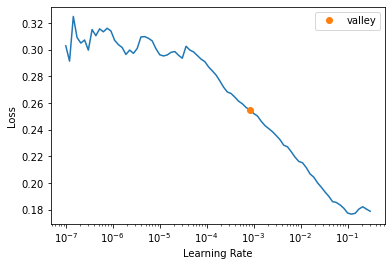

In [206]:
learn.lr_find()

In [207]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,_rmse,time
0,0.016624,7297325072384.000000,2701356.000000,00:11
1,0.014429,14073274040320.000000,3751436.500000,00:11
2,0.014665,9039135113216.000000,3006516.250000,00:11
3,0.014014,476781158433030144.000000,690493440.000000,00:11
4,0.013817,67593770343203864576.000000,8221545984.000000,00:11
5,0.012759,3323949819726135296.000000,1823170816.000000,00:11
6,0.011552,11088927709353476096.000000,3330003456.000000,00:11
7,0.010957,401168808942764032.000000,633378752.000000,00:11
8,0.010345,146631025299030016.000000,382924288.000000,00:11
9,0.011613,8572326463036981248.000000,2927853568.000000,00:11


In [208]:
learn.show_results()

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [187]:
ts_features_df.iloc[splits_2[0]][ts_features_df.columns[:-1]].to_parquet(data_root + '5.MLData/X_tab_train.parquet')

In [188]:
ts_features_df.iloc[splits_2[0]][ts_features_df.columns[-1]].to_csv(data_root + '5.MLData/y_tab_train.csv')
ts_features_df.iloc[splits_2[1]][ts_features_df.columns[:-1]].to_parquet(data_root + '5.MLData/X_tab_test.parquet')
ts_features_df.iloc[splits_2[1]][ts_features_df.columns[-1]].to_csv(data_root + '5.MLData/y_tab_test.csv')

In [30]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [79]:

rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
reg = MiniRocketRegressor(scoring=rmse_scorer)
reg.fit(X_final, y_final)
y_pred = reg.predict(X_test_final)
mean_squared_error(y_test_final, y_pred, squared=False)

3.031185277181349

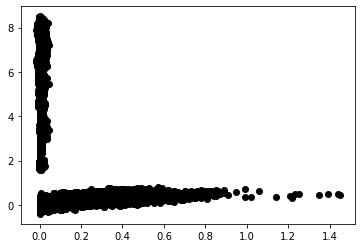

In [82]:

plt.scatter(y_test_final, y_pred, color="black")

In [34]:

#can use a smaller train subset to make development faster
splits_2 = (L([i for i in range(0,len(y_final))]).shuffle(), L([i for i in range(len(y_final),len(y_final)+len(y_test_final))]).shuffle())

In [35]:
splits_2

((#1659) [736,161,395,883,1586,1162,571,1007,164,992...],
 (#237) [1731,1875,1863,1785,1847,1764,1841,1776,1676,1831...])

In [43]:
pd.DataFrame(X_final[0])

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.000000,0.000000,0.000000,8.280000,0.390000,0.000000,0.000000,0.000000,0.000000,0.180000,...,0.000000,0.140000,0.500000,0.000000,1.020000,0.190000,0.110000,1.790000,0.030000,6.720000
1,0.000000,0.000000,0.000000,13.259999,17.160000,0.800000,0.000000,0.000000,0.000000,0.160000,...,0.300000,5.920000,0.500000,0.000000,1.170000,0.200000,0.100000,11.420000,1.220000,24.700001
2,2312.160645,2312.160645,2312.160645,2312.160645,2312.160645,2312.160645,2312.160645,2312.160645,2312.160645,2312.160645,...,2312.160645,2312.160645,2312.160645,2312.160645,2312.160645,2312.160645,2312.160645,2312.160645,2312.160645,2312.160645
3,273.200012,275.399994,275.299988,276.600006,271.100006,268.799988,265.500000,267.000000,270.399994,270.799988,...,266.200012,273.600006,272.399994,276.399994,277.200012,271.899994,274.500000,272.399994,269.899994,274.100006
4,1.700000,2.970000,4.490000,1.620000,4.240000,3.310000,0.800000,0.560000,3.360000,3.990000,...,2.430000,2.500000,0.460000,5.220000,13.370000,7.320000,3.140000,4.860000,2.330000,2.050000
5,1.400000,6.590000,17.789999,10.080000,2.040000,0.680000,1.240000,2.550000,6.490000,11.520000,...,1.800000,2.000000,0.450000,10.040000,17.459999,-0.450000,17.000000,7.640000,0.180000,7.090000
6,-0.060671,-0.042100,-0.057300,-0.004800,-0.047386,-0.023000,0.044257,-0.014743,-0.095071,-0.031686,...,-0.004743,-0.011186,-0.013429,-0.027971,-0.097386,-0.062200,-0.143357,-0.020214,-0.022971,-0.045271
7,0.000000,0.000000,0.000000,0.300000,0.033600,0.001600,0.017600,0.019200,0.015200,0.004800,...,0.081600,0.113600,0.416000,0.070400,0.021600,0.013600,0.016400,0.083200,0.045600,0.574400
8,0.000000,0.000000,0.000000,3.000000,18.000000,1.000000,4.000000,4.000000,4.000000,3.000000,...,10.000000,13.000000,9.000000,4.000000,0.000000,1.000000,0.000000,9.000000,2.000000,15.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [47]:
pd.DataFrame(X_test_final[0])

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,5.000000,5.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2112.540039,2112.540039,2112.540039,2112.540039,2112.540039,2112.540039,2112.540039,2112.540039,2112.540039,2112.540039,...,-0.220000,-2.160000,-2.260000,-2.570000,-2.840000,-3.120000,-3.180000,-0.290000,-1.280000,-1.950000
3,273.100006,273.700012,275.299988,274.299988,274.000000,278.200012,279.200012,269.399994,270.299988,262.799988,...,-5.280000,-1.280000,-1.980000,-6.360000,-0.160000,0.220000,1.700000,-2.980000,-4.920000,-3.360000
4,1.240000,1.510000,2.060000,2.420000,0.030000,3.450000,0.600000,4.980000,1.970000,1.390000,...,-14.812858,-14.614286,-12.212858,-6.825714,-20.000000,-16.794285,-19.871429,7.428571,-14.088572,-20.000000
5,2.160000,1.630000,1.480000,0.880000,1.300000,11.060000,9.360000,13.730000,6.370000,2.770000,...,22759.916016,23777.357422,24135.029297,21600.701172,24134.972656,24135.072266,24134.957031,18035.027344,23398.683594,24135.015625
6,-0.014286,-0.025714,0.028286,0.006857,0.007714,-0.153143,0.189714,0.580429,-0.017000,-0.062571,...,225.985718,225.784286,226.117157,224.458572,228.001434,229.302856,230.618576,227.108566,226.984283,231.865723
7,0.031600,0.038400,0.033200,0.028000,0.030800,0.032800,0.052800,0.056000,0.037200,0.035600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,3.000000,...,-6.600000,13.300000,18.500000,8.200000,1.100000,14.000000,36.700001,44.200001,4.000000,-28.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:>

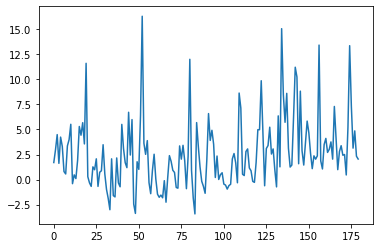

In [36]:
pd.DataFrame(X_final[0]).iloc[4].plot()

<AxesSubplot:>

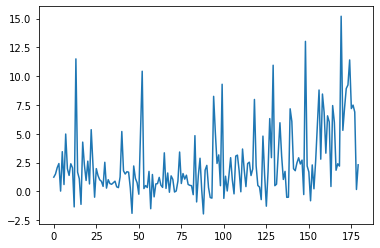

In [38]:
pd.DataFrame(X_test_final[0]).iloc[4].plot()

In [39]:
np.concatenate([y_final, y_test_final]).shape

(1896,)

In [66]:
np.concatenate([y_final, y_test_final])

array([0.03, 0.02, 0.25, ..., 0.01, 0.02, 0.01])

In [56]:
tfms  = [None, [TSRegression()]]
batch_tfms = [TSStandardize(by_sample=False, by_var=True), Nan2Value()]
dls = get_ts_dls(np.concatenate([X_final, X_test_final]), np.concatenate([y_final, y_test_final]), splits=splits_2, tfms=tfms, batch_tfms=batch_tfms, bs=64)

In [57]:
np.concatenate([X_final, X_test_final]).shape

(1896, 10, 180)

In [58]:
#TODO: the standarize isn't working for the valid batch

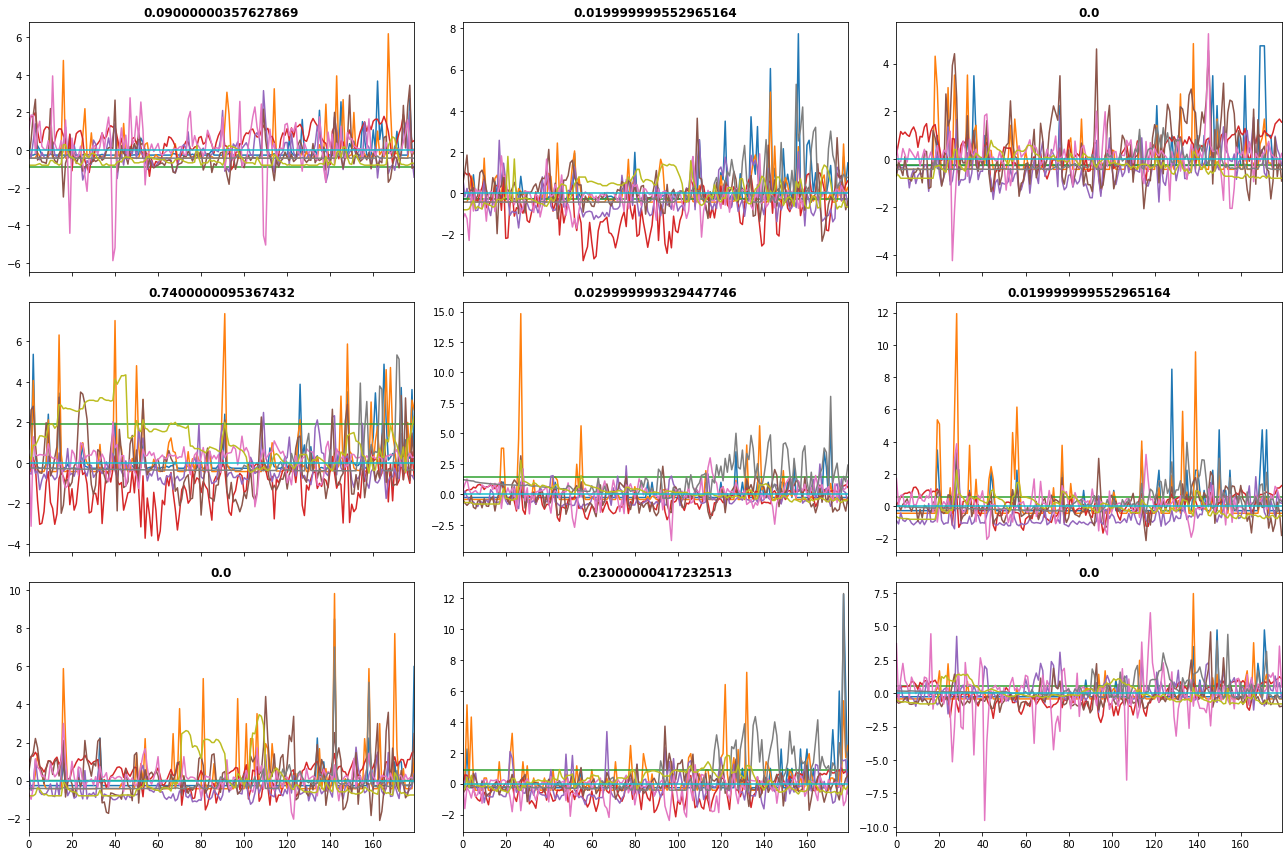

In [59]:
dls.train.show_batch()

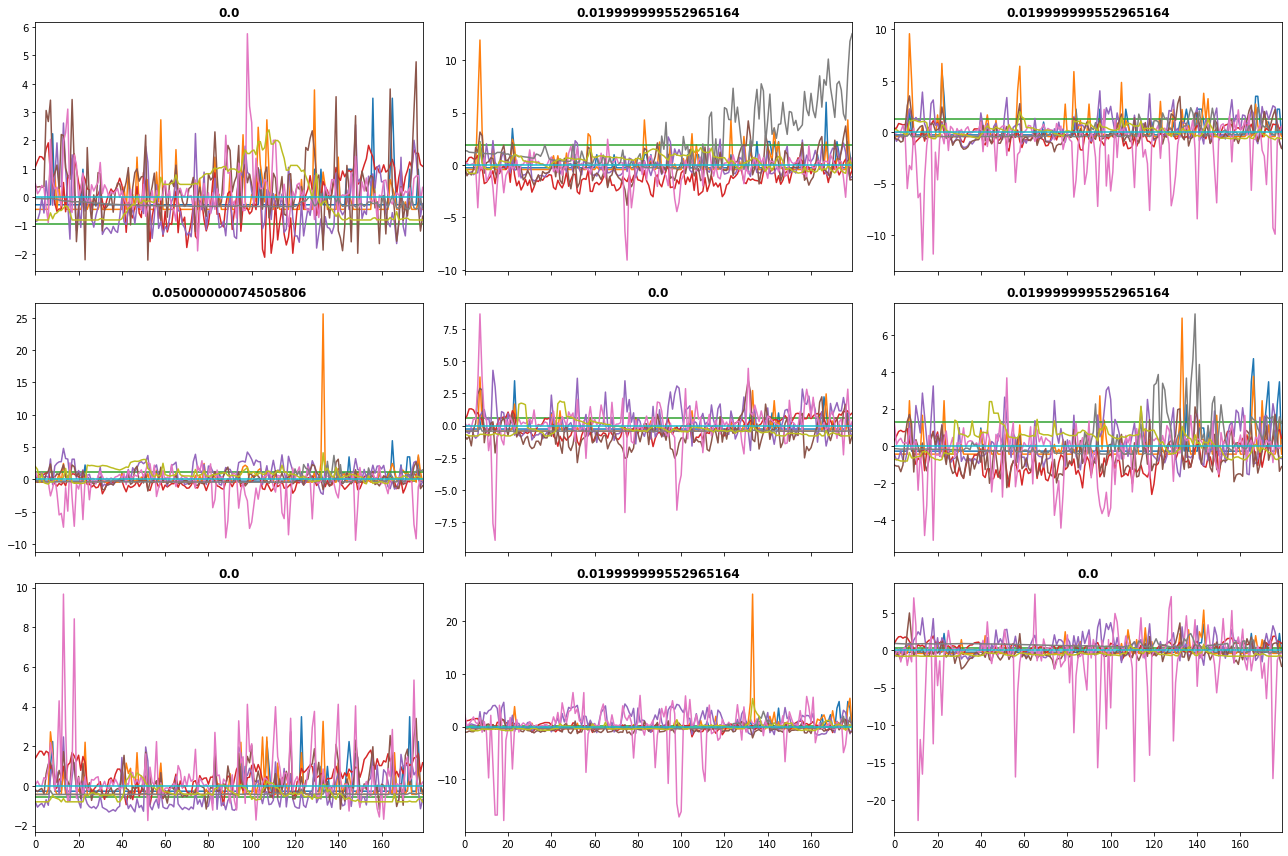

In [60]:
dls.valid.show_batch()

In [61]:
learn = ts_learner(dls, InceptionTimePlus, metrics=[mae, rmse], cbs=ShowGraph())

/home/scottcha/miniconda3/envs/tsai.22nocaputm/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=6.309573450380412e-07)

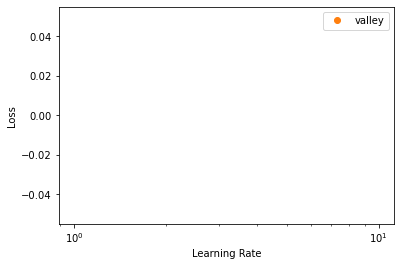

In [62]:
learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,nan,nan,nan,nan,00:00
1,nan,nan,nan,nan,00:00
2,nan,nan,nan,nan,00:00
3,nan,nan,nan,nan,00:00
4,nan,nan,nan,nan,00:00


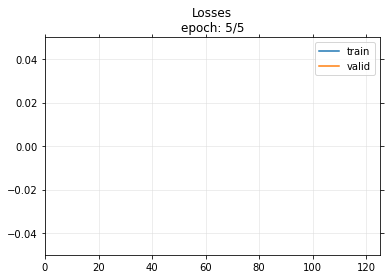

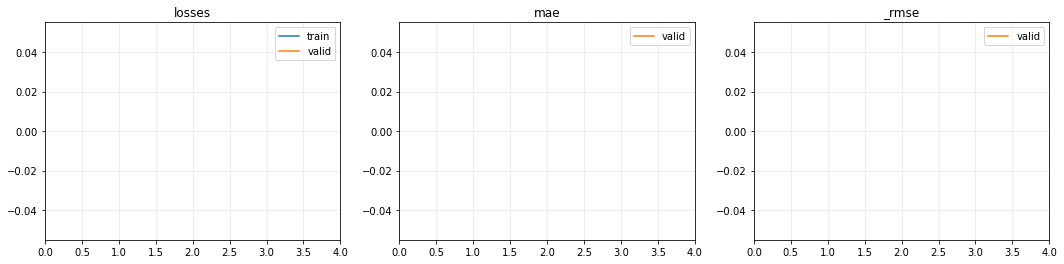

In [63]:
learn.fit_one_cycle(5, 1e-2)

In [56]:
probas, _, preds = learn.get_X_preds(X_test_final)
skm.mean_squared_error(y_test_final, preds, squared=False)

99.37084143974022

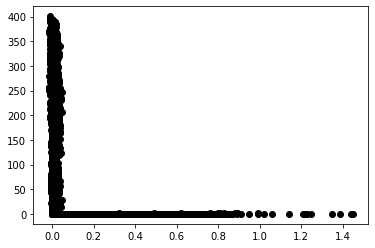

In [57]:

plt.scatter(y_test_final, preds, color="black")

In [42]:
?plt.scatter

In [58]:
pd.Series(y_test_final).describe()

count    35787.000000
mean         0.126425
std          0.144668
min         -0.018000
25%          0.009000
50%          0.070000
75%          0.210000
max          1.450000
dtype: float64

In [59]:
pd.Series(zip(y_test_final, preds))

0           (0.009999999776482582, [tensor(0.0288)])
1           (0.009999999776482582, [tensor(0.0163)])
2           (0.009999999776482582, [tensor(0.0161)])
3           (0.009999999776482582, [tensor(0.0163)])
4          (0.009999999776482582, [tensor(-0.0069)])
                            ...                     
35782     (0.004000000189989805, [tensor(242.6227)])
35783     (0.023000000044703484, [tensor(230.4029)])
35784     (0.004000000189989805, [tensor(236.5839)])
35785    (-0.014000000432133675, [tensor(251.7146)])
35786      (0.00800000037997961, [tensor(258.1377)])
Length: 35787, dtype: object